In [ ]:
!git clone https://github.com/Chandu-4444/Data-Science

fatal: destination path 'Data-Science' already exists and is not an empty directory.


In [ ]:
import os

os.chdir("/content/Data-Science/Zindi/Armyworm Challenge")

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
import shutil
import time
import copy

import tqdm
import skimage.transform


In [ ]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

In [ ]:
train_df.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


In [ ]:
# !mkdir train_images

In [ ]:
# !mkdir train_images/0
# !mkdir train_images/1

In [ ]:
# !mkdir val_images
# !mkdir val_images/0
# !mkdir val_images/1

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(np.array(train_df.drop("Label", axis=1)), np.array(train_df["Label"]), test_size=0.3, shuffle=True)

In [ ]:
# for img, label in zip(X_train, y_train):
#     source_path = "images/" + img.item()
#     dest_path = "train_images/" + str(label)
#     shutil.copy(source_path, dest_path)

In [ ]:
# for img, label in zip(X_val, y_val):
#     source_path = "images/" + img.item()
#     dest_path = "val_images/" + str(label)
#     shutil.copy(source_path, dest_path)

In [ ]:
import torch
import torchvision

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(255),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomGrayscale(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(255),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = torchvision.datasets.ImageFolder("train_images/", train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder("val_images/", val_transforms)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

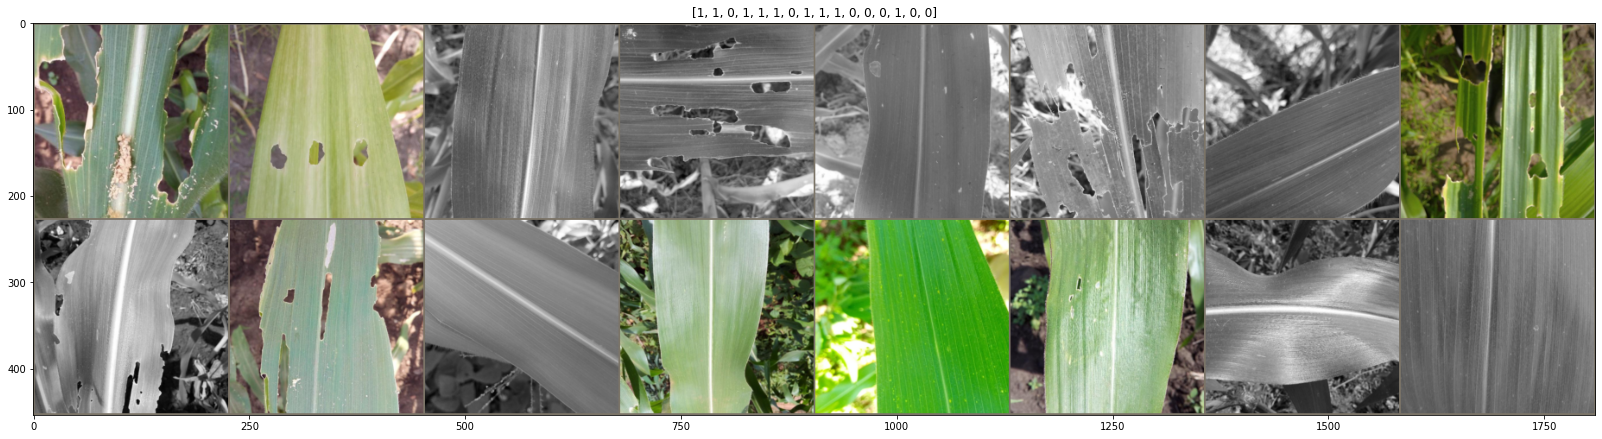

In [ ]:
def show_batch(img, title=None):
    plt.figure(figsize=(28, 10))
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = mean + img * std
    img = np.clip(img, 0, 1)    
    if title is not None:
        plt.title(title)
    plt.imshow(img)

inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

show_batch(out, title=[x.item() for x in classes])

In [ ]:
dataloader = {
    "train": train_dataloader,
    "val": val_dataloader 
}

datasize = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(DEVICE)

cuda


In [ ]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = torch.nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_top5 = 0.0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0 
            running_top5 = 0
            

            with tqdm.tqdm(dataloader[phase], unit="batch") as bar:
                for inputs, labels in bar:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    
                    # Zero the parametsrs
                    optimizer.zero_grad()
                    
                    # Forward
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                        
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    
                    bar.set_postfix(loss=loss.item())
                
                if phase == "train":
                    scheduler.step()
                
                epoch_loss = running_loss / datasize[phase]
                epoch_acc = running_corrects.double()/datasize[phase]
                
                print()
                print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                if(phase == "val" and epoch_acc > best_acc):
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f \n".format(best_acc))
    
    # load best model parameters
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=5)

Epoch 0/4
----------


100%|██████████| 71/71 [00:35<00:00,  2.02batch/s, loss=0.0536]



train Loss: 0.2796 Acc: 0.8870


100%|██████████| 31/31 [00:10<00:00,  2.91batch/s, loss=0.0126]



val Loss: 0.0533 Acc: 0.9897

Epoch 1/4
----------


100%|██████████| 71/71 [00:31<00:00,  2.26batch/s, loss=0.0226]



train Loss: 0.0761 Acc: 0.9771


100%|██████████| 31/31 [00:10<00:00,  2.88batch/s, loss=0.0112]



val Loss: 0.0400 Acc: 0.9897

Epoch 2/4
----------


100%|██████████| 71/71 [00:30<00:00,  2.35batch/s, loss=0.00407]



train Loss: 0.0797 Acc: 0.9718


100%|██████████| 31/31 [00:10<00:00,  2.91batch/s, loss=0.00306]



val Loss: 0.0276 Acc: 0.9918

Epoch 3/4
----------


100%|██████████| 71/71 [00:30<00:00,  2.35batch/s, loss=0.0513]



train Loss: 0.0564 Acc: 0.9806


100%|██████████| 31/31 [00:10<00:00,  2.89batch/s, loss=0.00398]



val Loss: 0.0150 Acc: 0.9959

Epoch 4/4
----------


100%|██████████| 71/71 [00:30<00:00,  2.36batch/s, loss=0.0252]



train Loss: 0.0386 Acc: 0.9823


100%|██████████| 31/31 [00:10<00:00,  2.92batch/s, loss=0.00175]


val Loss: 0.0109 Acc: 0.9959

Training complete in 3.000000m 30.743748s
Best val Acc: 0.9958847736625516:4f 



In [ ]:
# !mkdir test_images/
# !mkdir test_images/test

In [ ]:
# for img in test_df["Image_id"]:
#     source_path = "images/" + img
#     dest_path = "test_images/test"
#     shutil.copy(source_path, dest_path)

In [ ]:
torch.save(model_ft, "model.pt")

In [124]:
test_dataset = torchvision.datasets.ImageFolder("test_images/", val_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle=False)

In [ ]:
probs = []
model_ft.eval()
with torch.no_grad():
    for data, fileid in test_dataloader:
        data = data.to(DEVICE)
        preds = model_ft(data)
        probs.append(preds)

In [ ]:
final_preds = []

for batch_preds in probs:
    # print(torch.argmax(batch_preds, dim=1))
    for prediction in torch.argmax(batch_preds, dim=1):
        final_preds.append(prediction.detach().cpu().item())
    

In [ ]:
submission = test_df.copy()

In [ ]:
submission["Label"] = final_preds

In [165]:
submission.head(10)

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0
1,id_03dqinf6w0znv.jpg,0
2,id_046yl0cxn3ybz.jpg,1
3,id_04athdtx2abyg.jpg,0
4,id_062aauf9e9jk0.jpg,0
5,id_0695b3b665yet.jpg,0
6,id_06cueqs5yhekm.jpg,1
7,id_0826dbdkr8sxr.jpg,1
8,id_09re5drh85tbo.jpg,0
9,id_0adud1myz8tvz.jpg,0


In [195]:
infected = submission[submission["Label"] == 1]
infected.head()

,Image_id,Label
2,id_046yl0cxn3ybz.jpg,1
6,id_06cueqs5yhekm.jpg,1
7,id_0826dbdkr8sxr.jpg,1
10,id_0ahjbw1wygbq0.jpg,1
11,id_0ap0rrztgzllj.jpg,1


In [ ]:
import PIL

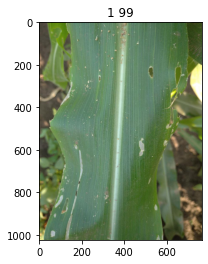

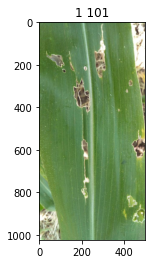

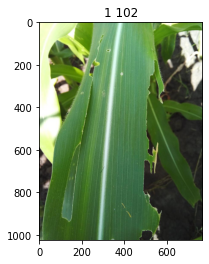

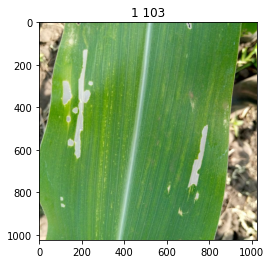

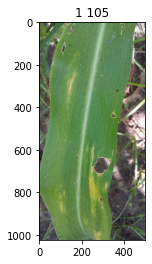

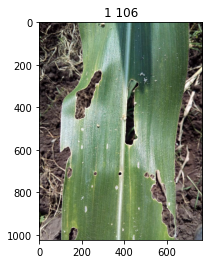

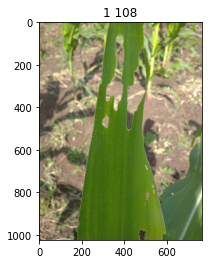

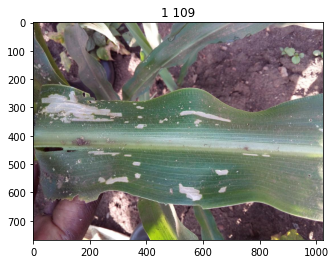

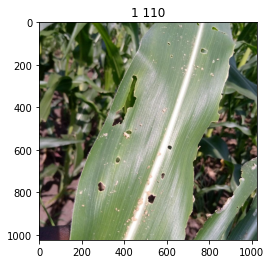

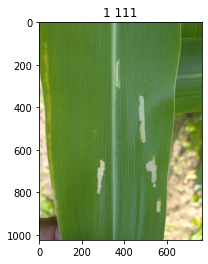

In [225]:
# plt.figure(figsize=(28, 10))
# plt.subplots(5, 2, figsize=(28, 10))


# count = 1
for row in np.array(infected.iloc[50:60]):
    # print(row)
    # break
    # idx = row[0]
    image = row[0]
    label = row[1]
    # plt.subplot(5, 2, count)
    # count += 1
    # image, label = submission.iloc[idx]["Image_id"], submission.iloc[idx]["Label"]
    plt.imshow(PIL.Image.open(f"test_images/test/{image}"))
    plt.title(str(label) +" "+ str(infected[infected["Image_id"] == image].index.item()))
    plt.show()

In [ ]:
submission.to_csv("Submission.csv", index=False)

In [95]:
target_layers = [model_ft.layer4[-1]]

In [181]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=False)
images, label = next(iter(test_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


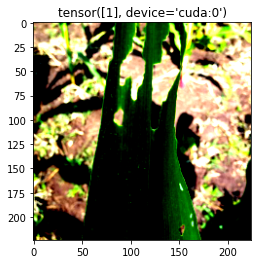

In [226]:
idx = 108
input_tensor = images[idx]
img = images[idx].numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.title(torch.argmax(model_ft(images[idx].unsqueeze(0).to(DEVICE)), dim=1))
plt.show()

In [142]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [144]:
final_layer = model_ft._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

In [227]:
prediction_var = torch.autograd.Variable((images[108].unsqueeze(0)).cuda(), requires_grad=True)

In [228]:
prediction = model_ft(prediction_var)
pred_probabilities = torch.nn.functional.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [229]:
class_idx = torch.topk(pred_probabilities,1)[1].int()

class_idx

tensor([1], device='cuda:0', dtype=torch.int32)

In [230]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [231]:
weight_softmax_params = list(model_ft._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [232]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

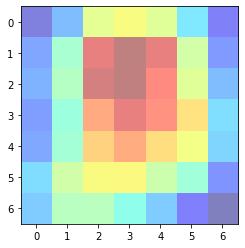

In [233]:
plt.imshow(overlay[0], alpha=0.5, cmap='jet')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


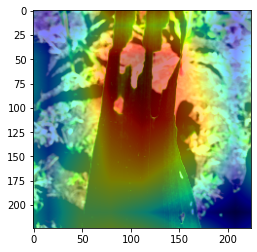

In [234]:
plt.imshow(images[108].numpy().transpose(1, 2, 0))
plt.imshow(skimage.transform.resize(overlay[0], images[108].shape[1:3]), alpha=0.5, cmap='jet');